In [1]:

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from scipy.stats import randint, uniform
from xgboost import XGBRFRegressor, XGBRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

import tensorflow
import seaborn
import pandas
import numpy

import warnings

warnings.filterwarnings('ignore')


In [2]:

target = 'target'
flag = 'imbalance_buy_sell_flag'
far_near_flag = 'has_far_and_near_price'
base_dir = 'C:\\Users\\Michael\\Downloads\\'

engineered_features = ['spread']
flag_features = ['sell_imbalance', 'no_imbalance', 'buy_imbalance']
exclude = ['row_id', 'stock_id', 'date_id', 'time_id', flag, far_near_flag, target] + flag_features
log_features = ['imbalance_size', 'reference_price', 'matched_size', 'bid_price', 'bid_size', 'ask_price', 'ask_size',
                'wap', 'spread', 'far_price', 'near_price']


In [3]:

def train_test_split(data, train_size_ratio):
    
    at = train_size_ratio * data['date_id'].max() + (1 - train_size_ratio) * data['date_id'].min()
    
    return data[data['date_id'] <= at], data[data['date_id'] > at]


In [4]:

train, test = train_test_split(pandas.read_csv(base_dir + 'train.csv'), 0.8)
vali = pandas.read_csv(base_dir + 'test.csv')
targets = pandas.read_csv(base_dir + 'revealed_targets.csv')

vali = vali.merge(targets, how='outer', left_on=['stock_id', 'date_id', 'seconds_in_bucket'],
           right_on=['stock_id', 'date_id', 'seconds_in_bucket'])

vali.rename(columns={'revealed_target':target}, inplace=True)


In [5]:

features = [i for i in train.columns if not i in exclude] + engineered_features


In [6]:

# one-hot-encoding and inverse one-hot-encoding
def ohe(y): return numpy.array(y[...,None] == numpy.array([[-1,0,1]])[None,...], dtype=numpy.float32)[0,...]
def iohe(y): return (y * numpy.array([-1,0,1])[None,...]).sum(axis=-1)

# use the means from the training set on the test set to fill nan values
def preprocess_data(data):
    
    # turn the imbalance flag into three separate flags (one-hot-encoding)
    data[flag_features] = ohe(data[flag])
    
    # indicate that both far and near prices are not nan
    data[far_near_flag] = 1.0 - data[['far_price', 'near_price']].isnull().any(axis=1)
    
    data['far_price'].fillna(0.0, inplace=True)
    data['near_price'].fillna(0.0, inplace=True)
    
    data['spread'] = data['ask_price'] - data['bid_price']
    #data['liq_imbalance'] = (data['bid_size'] - data['ask_size']) / (data['bid_size'] + data['ask_size'] + 1)
    
    data.dropna(inplace=True)
    

In [7]:

preprocess_data(train)


In [8]:

train[features].isnull().sum()


seconds_in_bucket    0
imbalance_size       0
reference_price      0
matched_size         0
far_price            0
near_price           0
bid_price            0
bid_size             0
ask_price            0
ask_size             0
wap                  0
spread               0
dtype: int64

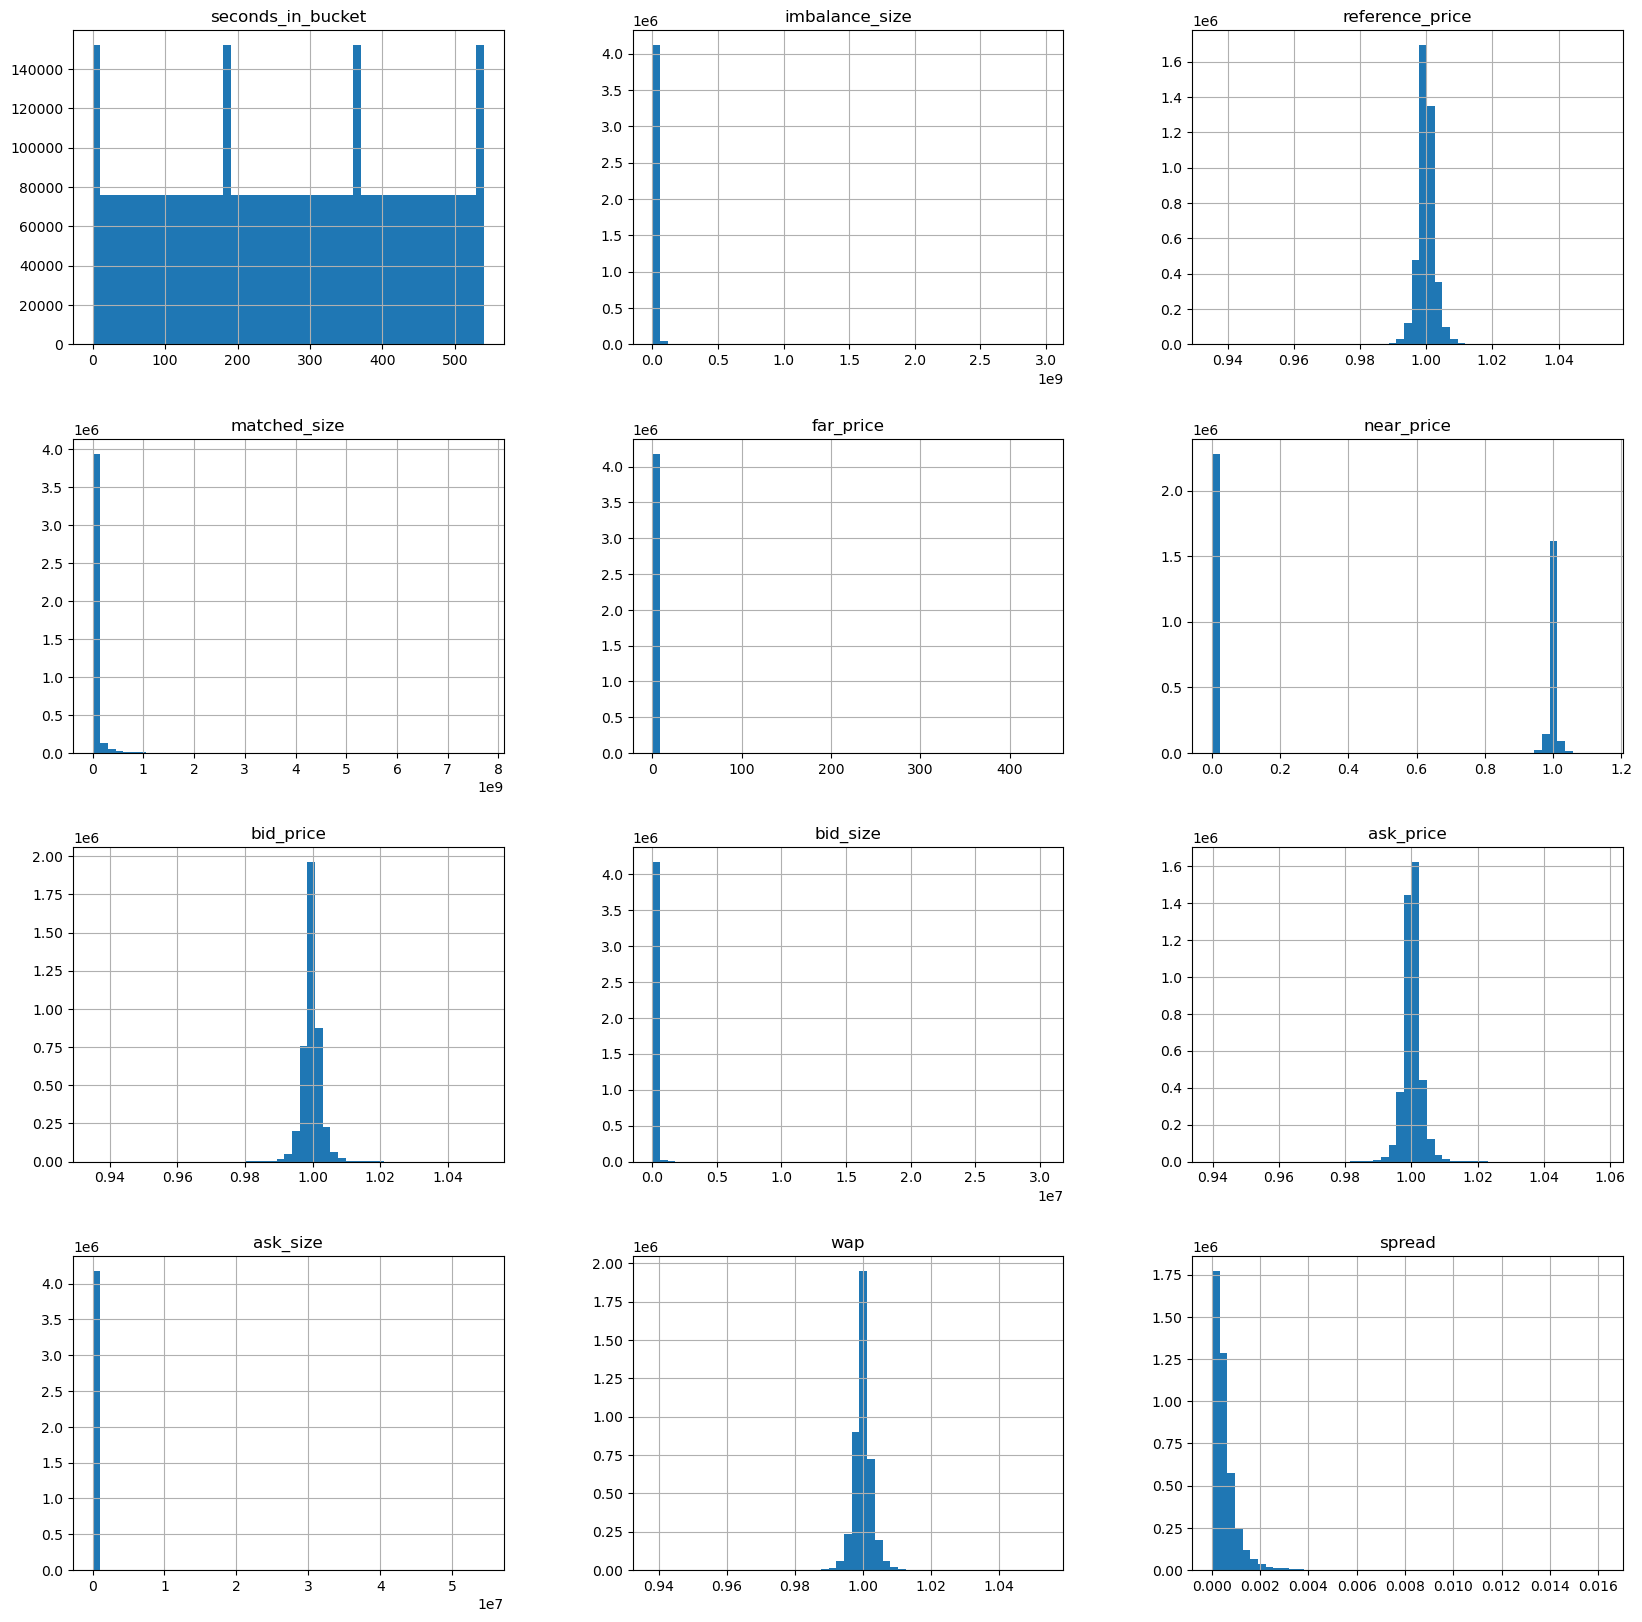

In [9]:

train[features].hist(bins=51, figsize=(20,20))

plt.show()


In [10]:

def transform(data, scaler, pca, imbalance_shift=None, fit=False):
    
    for feature in log_features:
        
        data[feature] = numpy.log(1e-9 + data[feature])
        
    if fit:
        imbalance_mean = data['imbalance_size'][data['no_imbalance']==0].mean()
        imbalance_std = data['imbalance_size'][data['no_imbalance']==0].std()
        
        near_price_mean = data['near_price'][data[far_near_flag]].mean()
        near_price_std = data['near_price'][data[far_near_flag]].std()
        
        far_price_mean = data['far_price'][data[far_near_flag]].mean()
        far_price_std = data['far_price'][data[far_near_flag]].std()
        
        scaler.fit(data[features])
        
        re_features = list(scaler.feature_names_in_)
        
        scaler.mean_[re_features.index('imbalance_size')] = imbalance_mean
        scaler.var_[re_features.index('imbalance_size')] = imbalance_std**2
        
        scaler.mean_[re_features.index('near_price')] = near_price_mean
        scaler.var_[re_features.index('near_price')] = near_price_std**2
        
        scaler.mean_[re_features.index('far_price')] = far_price_mean
        scaler.var_[re_features.index('far_price')] = far_price_std**2
        
    re_features = scaler.feature_names_in_
    
    data[re_features] = scaler.transform(data[re_features])
    
    data['near_price'][data[far_near_flag]<0.5] = 0.0
    data['far_price'][data[far_near_flag]<0.5] = 0.0
    
    if fit: pca.fit(data[re_features])
    
    data[re_features] = pca.transform(data[re_features])
    
    if imbalance_shift == None: imbalance_shift = numpy.abs(data['imbalance_size']).mean()
    
    data['imbalance_size'] = numpy.abs(data['imbalance_size']) - imbalance_shift
    
    return imbalance_shift

def inverse_transform(data, scaler, pca, imbalance_shift):
    
    data['imbalance_size'] += imbalance_shift
    
    re_features = scaler.feature_names_in_
    
    data[re_features] = pca.inverse_transform(data[re_features])
    
    np_ind = re_features.index('near_price')
    fp_ind = re_features.index('far_price')
    
    data['near_price'][data[far_near_flag]<0.5] = -scaler.mean_[np_ind] / scaler.var_[np_ind]
    data['far_price'][data[far_near_flag]<0.5] = -scaler.mean_[fp_ind] / scaler.var_[fp_ind]
    
    data[re_features] = scaler.inverse_transform(data[re_features])
    
    for feature in log_features:
        
        data[feature] = numpy.exp(data[feature]) - 1e-9
        
def postprocess_data(data, remove_outliers):
    
    if remove_outliers: data.drop(data[(data[features] ** 2 > 9).any(axis=1)].index, inplace=True)
    

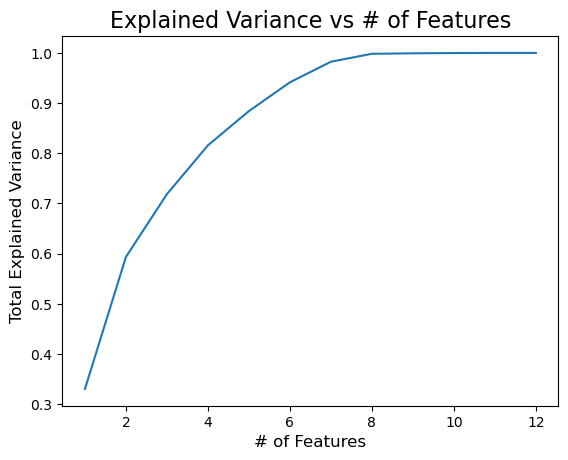

In [11]:

scaler = StandardScaler()
pca = PCA()

imbalance_shift = transform(train, scaler, pca, None, True)

postprocess_data(train, False)

all_features = features[:(pca.explained_variance_ratio_.cumsum() < 0.99).cumsum().max()] + flag_features + [far_near_flag]

preprocess_data(test)
transform(test, scaler, pca, imbalance_shift, False)
postprocess_data(test, False)

preprocess_data(vali)
transform(vali, scaler, pca, imbalance_shift, False)
postprocess_data(vali, False)

plt.plot(numpy.arange(len(scaler.feature_names_in_)) + 1, pca.explained_variance_ratio_.cumsum())

plt.title('Explained Variance vs # of Features', fontsize=16)
plt.ylabel('Total Explained Variance', fontsize=12)
plt.xlabel('# of Features', fontsize=12)

plt.show()


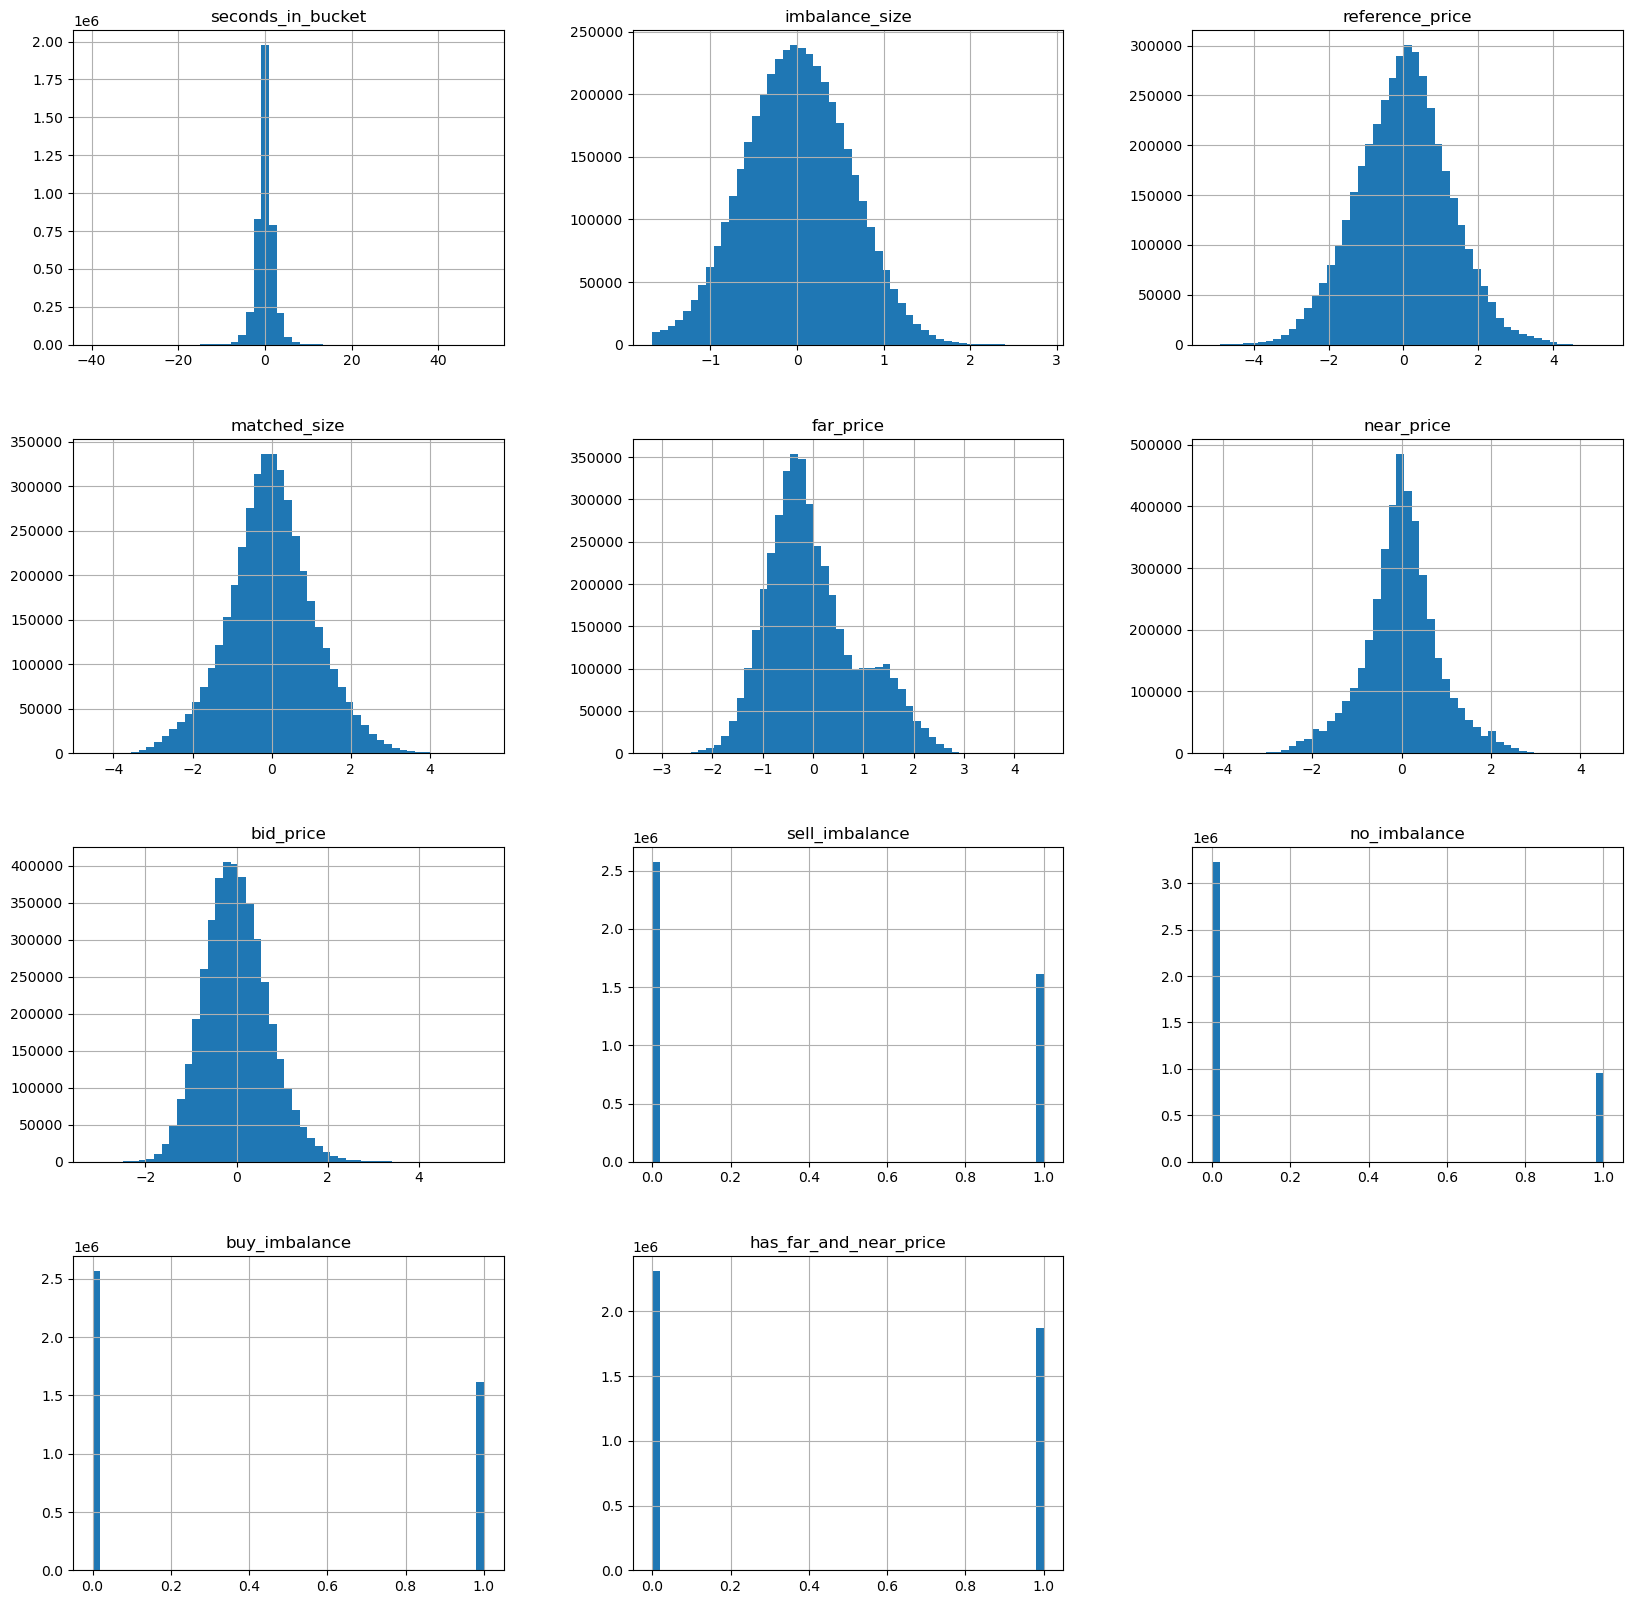

In [12]:

train[all_features].hist(bins=51, figsize=(20,20))

plt.show()


In [13]:

train[all_features].skew()


seconds_in_bucket        -0.232756
imbalance_size            0.013716
reference_price          -0.002059
matched_size              0.040257
far_price                 0.586068
near_price               -0.007945
bid_price                 0.344341
sell_imbalance            0.472121
no_imbalance              1.291081
buy_imbalance             0.468124
has_far_and_near_price    0.212496
dtype: float64

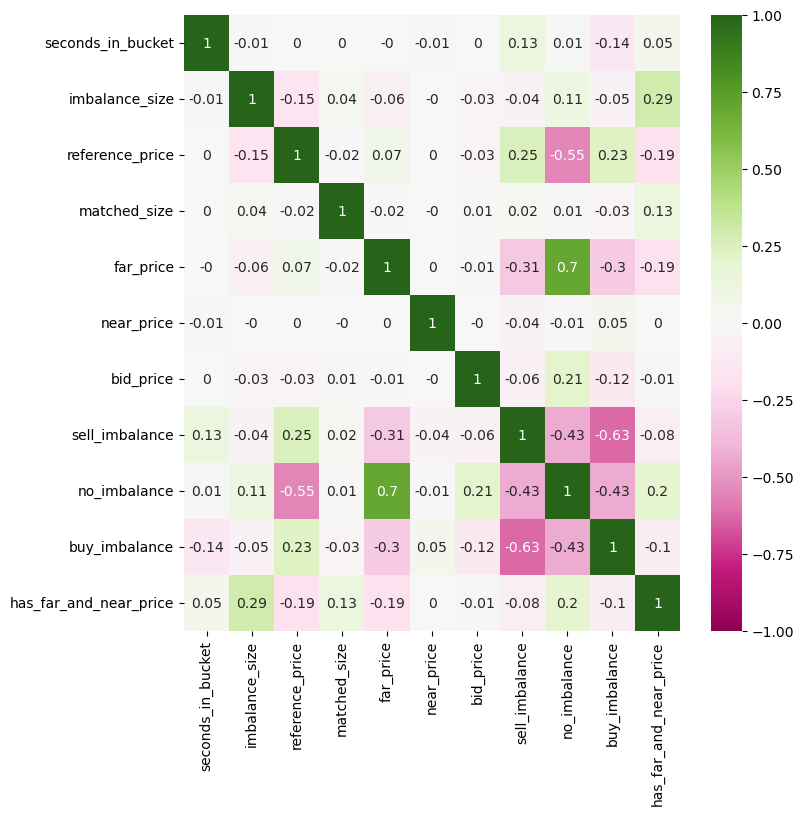

In [14]:

coefficients = train[all_features].corr(method='spearman').round(2)

plt.figure(figsize=(8, 8))

seaborn.heatmap(coefficients, annot=True, cmap='PiYG', vmin=-1, vmax=1)

plt.show()


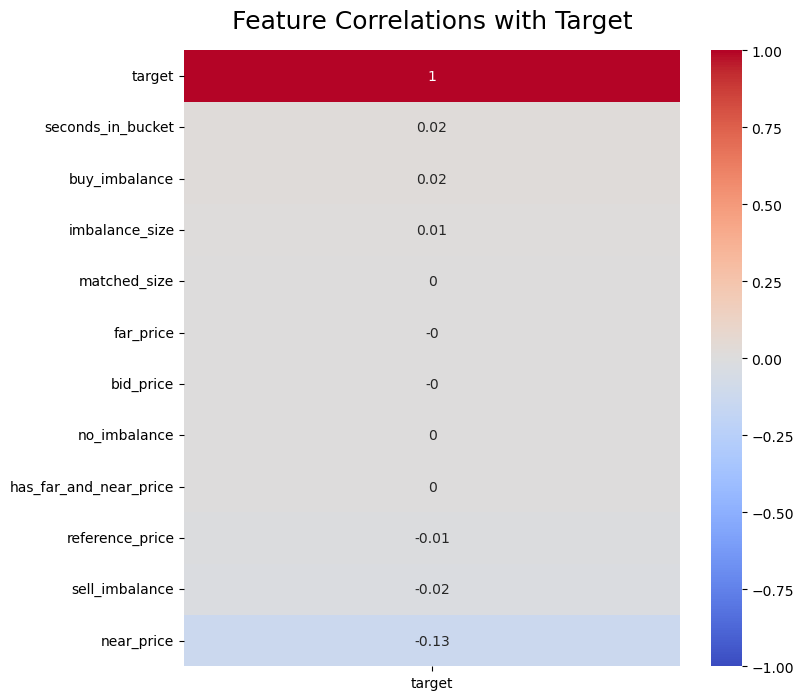

In [15]:

coefficients = train[all_features + [target]].corr(method='spearman').round(2)[[target]]

coefficients.sort_values(by=target, ascending=False, inplace=True)

plt.figure(figsize=(8, 8))

heatmap = seaborn.heatmap(coefficients, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

heatmap.set_title('Feature Correlations with Target', fontdict={'fontsize':18}, pad=16)

plt.show()


In [16]:

def relu(x): return tensorflow.keras.backend.relu(x, alpha=0.1) # leaky relu
def construct_nn(x, ff_dim0, ff_dim1, iters, epochs): # construct a neural net
    
    inputs = tensorflow.keras.layers.Input((len(x.columns),))
    
    for i in range(iters):
        if i == 0:
            dense0 = tensorflow.keras.layers.Dense(ff_dim0, activation=relu)(inputs)
            dense1 = tensorflow.keras.layers.Dense(ff_dim1, activation=relu)(dense0)
            
            continue
            
        dense0 = tensorflow.keras.layers.Dense(ff_dim0, activation=relu)(dense1)
        dense1 = tensorflow.keras.layers.Dense(ff_dim1, activation=relu)(dense0) + dense1
        
    outputs = tensorflow.keras.layers.Dense(1, activation=None)(dense1)
    model = tensorflow.keras.Model(inputs=inputs, outputs=outputs)
    adam = tensorflow.keras.optimizers.Adam(learning_rate=1e-3)
    
    model.compile(optimizer=adam, loss='mse', metrics=['mae'])
    
    class nn:
        
        def __init__(self, model):
            
            self.model = model
            
        def fit(self, x, y): self.model.fit(x, y, epochs=epochs, batch_size=256, verbose=1)
        def predict(self, x): return self.model.predict(x)[:,0]
        
    return nn(model)

class stackedModel:
    
    def __init__(self, base_models, meta_model):
        
        self.base_models = base_models
        self.meta_model = meta_model
        
    def fit(self, x, y):
        
        meta_data = numpy.zeros((len(x),len(self.base_models)))
        
        for index in range(len(self.base_models)):
            self.base_models[index].fit(x, y)
            meta_data[:,index] = self.base_models[index].predict(x)
            
            print('FINISHED TRAINING MODEL', index+1)
            
        self.meta_model.fit(numpy.concatenate([x, meta_data], axis=1), y)
        
    def predict(self, x):
        
        meta_data = numpy.zeros((len(x),len(self.base_models)))
        
        for index in range(len(self.base_models)): meta_data[:,index] = self.base_models[index].predict(x)
        
        return self.meta_model.predict(numpy.concatenate([x, meta_data], axis=1))
    

In [33]:

param_dist = {
    'n_estimators': randint(50, 500),            # Number of boosting rounds
    'learning_rate': uniform(1e-4, 1e-2),        # Learning rate
    'max_depth': randint(3, 9),                  # Maximum depth of trees
    'subsample': uniform(0, 1),                  # Subsample ratio of training instances
    'colsample_bytree': uniform(0, 1),           # Subsample ratio of columns when constructing each tree
    'reg_alpha': uniform(0, 1),                  # L1 regularization term on weights
    'reg_lambda': uniform(0, 1),                 # L2 regularization term on weights
}

lgbm_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 1e-3,
    'max_depth': 3,
    'n_estimators': 50,
    'num_leaves': 35,
    'reg_alpha': 0.4*0,
    'reg_lambda': 0.6*0,
    'subsample': 1.0,
    'boosting_type': 'gbdt',
    'n_jobs': 4,
    'random_state': 1024,
    'device': 'gpu'
}

xgb_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 1e-3,
    'max_depth': 3,
    'n_estimators': 50,
    'reg_alpha': 0.4*0,
    'reg_lambda': 0.6*0,
    'subsample': 1.0,
    'n_jobs': 4,
    'random_state': 1024
}

xgbrf_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 1e-3,
    'max_depth': 3,
    'n_estimators': 50,
    'reg_alpha': 0.4*0,
    'reg_lambda': 0.6*0,
    'subsample': 1.0,
    'n_jobs': 4,
    'random_state': 1024
}

hgb_params = {
    'max_leaf_nodes': 35,
    'learning_rate': 1e-3,
    'max_depth': 3,
    'random_state': 1024
}

model = stackedModel([LGBMRegressor(**lgbm_params),
                      XGBRegressor(**xgb_params),
                      XGBRFRegressor(**xgbrf_params),
                      HistGradientBoostingRegressor(**hgb_params),
                      LinearRegression()
                     ],
                     LGBMRegressor(max_depth=7, n_estimators=500, learning_rate=1e-3,
                                   num_leaves=35, n_jobs=4, random_state=1024, device='gpu'))

#construct_nn(train[all_features], 16, 8, 2, 10)

model.fit(train[all_features], train[target])

#params = {'n_jobs': 1, 'random_state': 1024}

"""
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10,
                                   scoring='neg_mean_absolute_error', cv=6, verbose=2, random_state=42, n_jobs=6)
# Perform randomized search
random_search.fit(train[all_features], train[target])

# Best parameters found during randomized search
print("Best parameters found during randomized search:")
print(random_search.best_params_)

# Best cross-validation score found during randomized search
print("Best cross-validation score found during randomized search:")
print(-random_search.best_score_)

# Keep the best model
model = random_search.best_estimator_
"""

# Evaluate model on train set
numpy.abs(model.predict(train[all_features]) - train[target]).mean()


FINISHED TRAINING MODEL 1
FINISHED TRAINING MODEL 2
FINISHED TRAINING MODEL 3
FINISHED TRAINING MODEL 4
FINISHED TRAINING MODEL 5


6.487893212983756

In [34]:

# Evaluate model on test set
numpy.abs(model.predict(test[all_features]) - test[target]).mean()


6.054275401051011

In [35]:

model.fit(pandas.concat([train[all_features], test[all_features]]), pandas.concat([train[target], test[target]]))

# Evaluate model on validation set
numpy.abs(model.predict(vali[all_features]) - vali[target]).mean()


FINISHED TRAINING MODEL 1
FINISHED TRAINING MODEL 2
FINISHED TRAINING MODEL 3
FINISHED TRAINING MODEL 4
FINISHED TRAINING MODEL 5


5.39129615629577